<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/007_TensorFlow_Proj_Seven_CNN_MNIST_FashionMNIST_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocess

In [7]:
import os, sys
import numpy as np
import pandas as pd
from collections import Counter
# google
from google.colab import drive
# sklearn
from sklearn.metrics import classification_report,confusion_matrix
# tensorflow
from tensorflow import one_hot
from tensorflow.config import list_physical_devices, experimental
from tensorflow.keras import Model, Sequential, layers, callbacks, applications, optimizers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, AUC
# vis
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
physical_devices = list_physical_devices("GPU")
experimental.set_memory_growth(physical_devices[0], True)

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


### MNISt Date Base

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


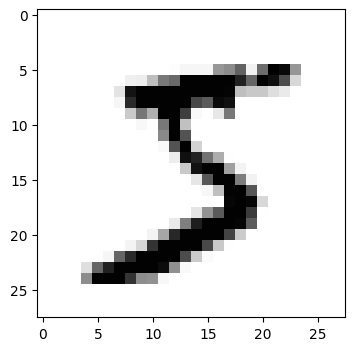

In [10]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

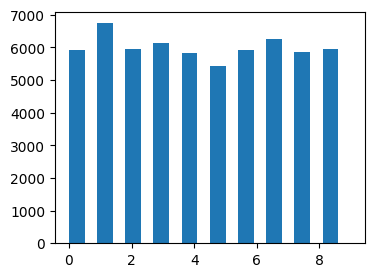

In [11]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

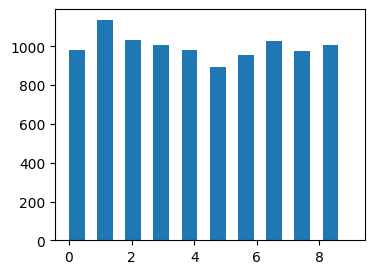

In [12]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [13]:
def ConvNet_builder():
  inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2],1), name="input_layer")
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="first_conv_layer")(inputs)
  feature = layers.MaxPool2D(pool_size=(2,2), name="first_pool_layer")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="second_conv_layer")(feature)
  feature = layers.MaxPool2D(pool_size=(2,2), name="second_pool_layer")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="third_conv_layer")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=64, activation="relu", name="first_dense_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="cnn_arc")
  model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [14]:
model = ConvNet_builder()
model.summary()

Model: "cnn_arc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_conv_layer (Conv2D)            │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool_layer (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_conv_layer (Conv2D)           │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool_layer (MaxPooling2D)     │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_conv_layer (Conv2D)            │ (None, 3, 3, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 64)                  │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,426 (220.41 KB)

 Trainable params: 56,426 (220.41 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto'),
                   callbacks.ModelCheckpoint(filepath="mnist_cnn.keras",save_best_only=True, monitor="val_loss")]
history = model.fit(x=x_train, y=y_train, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=[model_callbacks])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8148 - loss: 1.5617 - val_accuracy: 0.9776 - val_loss: 0.0827
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9766 - loss: 0.0775 - val_accuracy: 0.9797 - val_loss: 0.0671
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9846 - loss: 0.0517 - val_accuracy: 0.9825 - val_loss: 0.0625
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9896 - loss: 0.0351 - val_accuracy: 0.9855 - val_loss: 0.0647
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9912 - loss: 0.0299 - val_accuracy: 0.9845 - val_loss: 0.0684
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9917 - loss: 0.0271 - val_accuracy: 0.9887 - val_loss: 0.0502
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9862 - val_loss: 0.0782
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9932 - loss: 0.0237 - val_accuracy: 0.

In [17]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9881 - loss: 0.1079


[0.09652510285377502, 0.9904999732971191]

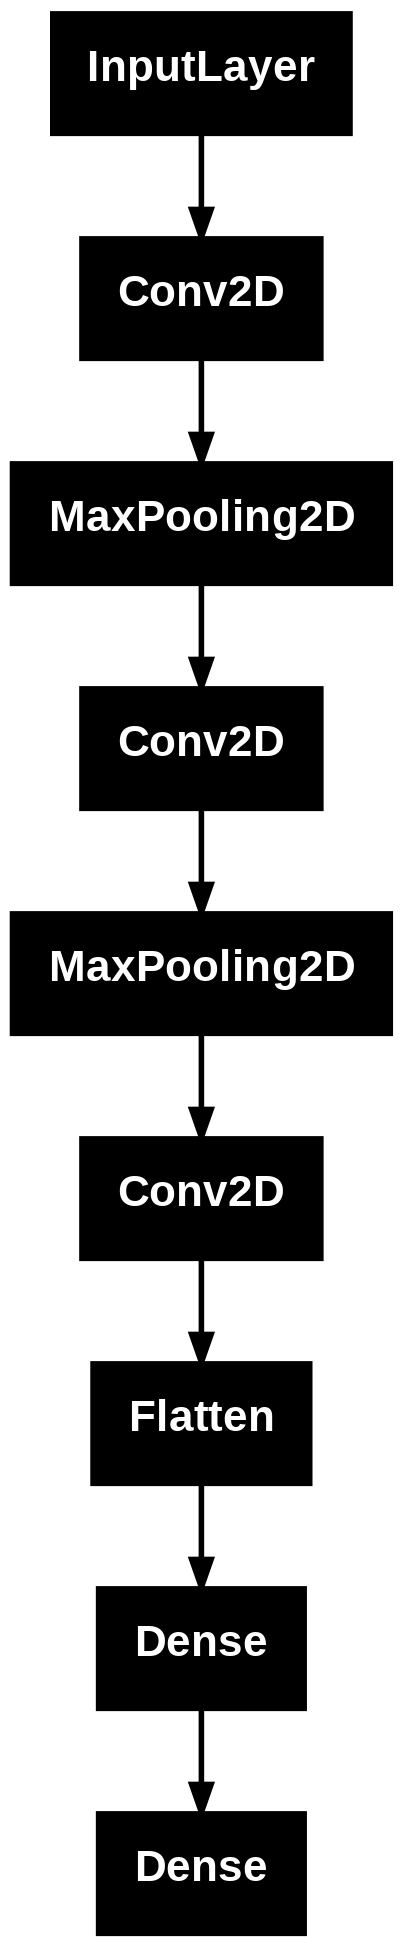

In [18]:
plot_model(model)

In [19]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [20]:
metrics = pd.DataFrame(history.history)
metrics

,accuracy,loss,val_accuracy,val_loss
0,0.916188,0.437256,0.977583,0.082697
1,0.978021,0.072686,0.979750,0.067124
2,0.984604,0.052025,0.982500,0.062509
3,0.988833,0.039625,0.985500,0.064735
4,0.990521,0.033605,0.984500,0.068438
5,0.991146,0.030932,0.988667,0.050166
6,0.993229,0.023612,0.986167,0.078212
7,0.993458,0.023950,0.987583,0.081465
8,0.994187,0.023052,0.985667,0.085076
9,0.994687,0.023299,0.987167,0.086626


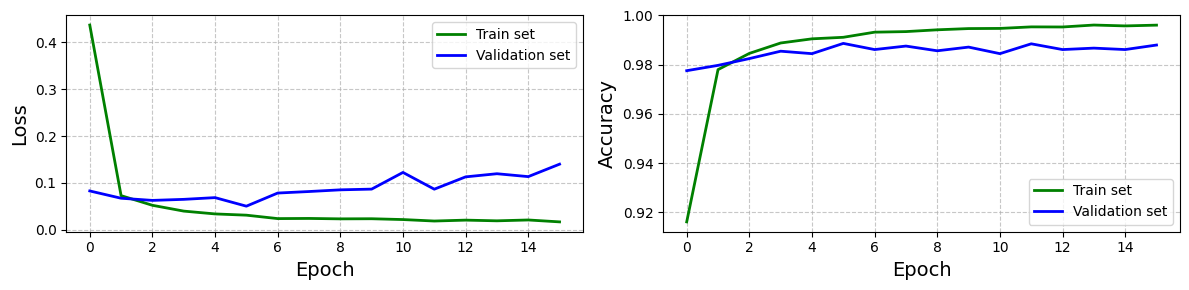

In [21]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [22]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [23]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [24]:
conf_mat = confusion_matrix(y_test,pred)
conf_mat

array([[ 976,    0,    1,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1128,    0,    2,    0,    3,    1,    0,    1,    0],
       [   1,    1, 1025,    0,    0,    0,    1,    3,    1,    0],
       [   0,    0,    2, 1002,    0,    5,    0,    0,    1,    0],
       [   0,    2,    0,    0,  968,    0,    3,    0,    0,    9],
       [   1,    0,    0,    4,    0,  882,    1,    1,    1,    2],
       [   3,    2,    0,    0,    0,    1,  950,    0,    2,    0],
       [   0,    8,    0,    2,    0,    0,    0, 1015,    0,    3],
       [   1,    2,    1,    2,    0,    0,    1,    1,  964,    2],
       [   0,    1,    0,    1,    4,    5,    0,    2,    1,  995]])

<Axes: >

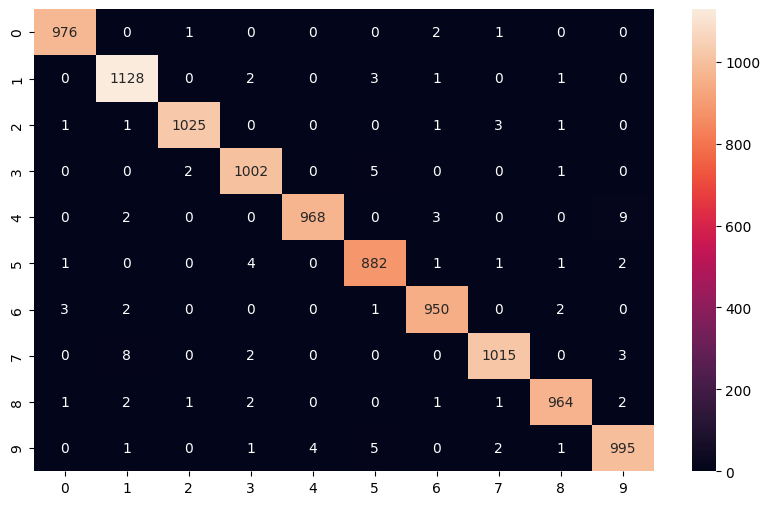

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat,annot=True, fmt='g')

In [26]:
misclf_img = [i for i, img in enumerate(y_test!=pred) if img==True]
len(misclf_img)

95

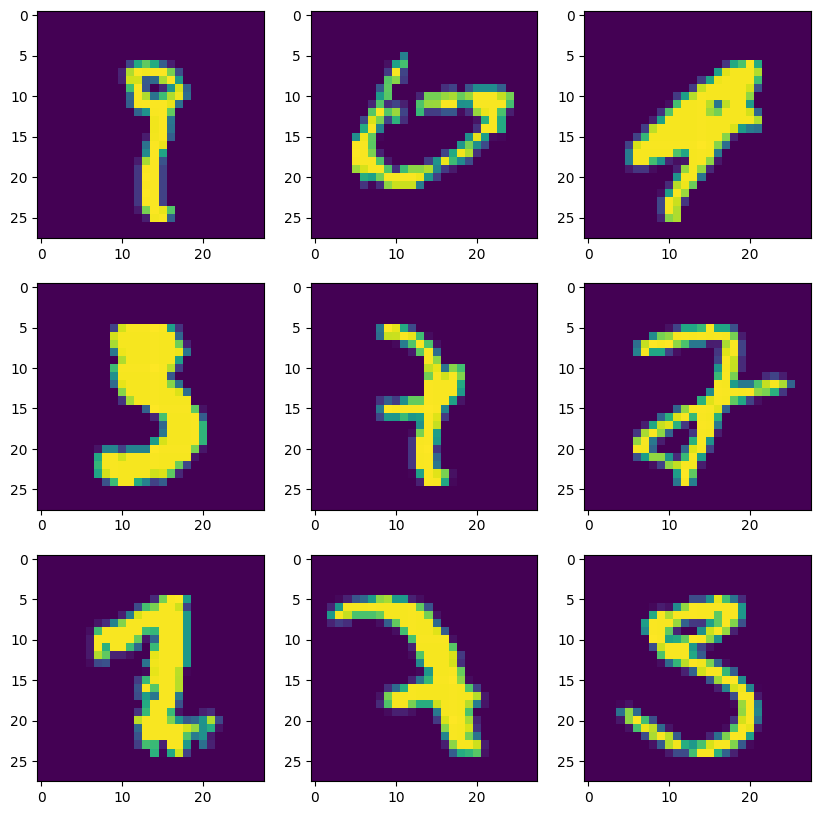


true_label [9, 6, 4, 3, 7, 2, 2, 7, 3]
wrong_pred [8, 0, 9, 5, 3, 7, 1, 9, 5]


In [27]:
plt.figure(figsize=(10,10))
true_label = []
wrong_pred = []
for idx , num in enumerate(misclf_img[:9]):
  ax = plt.subplot(3,3,idx+1)
  plt.imshow(x_test[num])
  true_label.append(y_test[num])
  wrong_pred.append(pred[num])
plt.show()
print("\ntrue_label", true_label)
print("wrong_pred", wrong_pred)

### Fashion MNISt Date Base

In [28]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


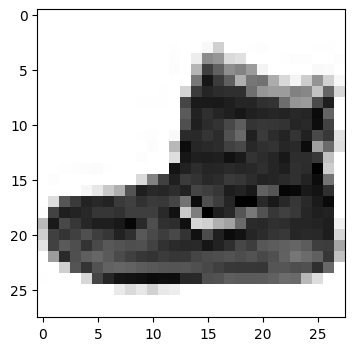

In [30]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

In [31]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

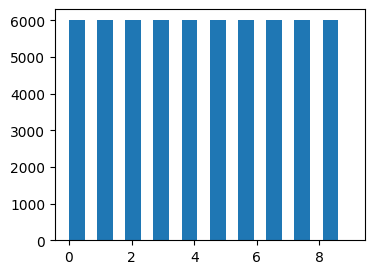

In [32]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

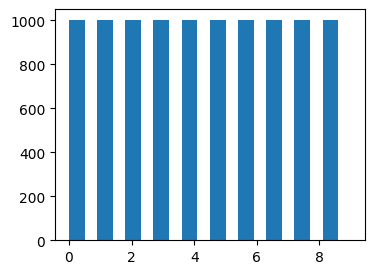

In [33]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [34]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train = x_train / 255.0
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test = x_test / 255.0

In [35]:
y_train_enc = to_categorical(y_train, num_classes=10)
y_test_enc = to_categorical(y_test, num_classes=10)

In [36]:
def ConvNetBuilder():

  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")

  inputs = layers.Input(shape=x_train.shape[1:], name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                metrics=[Precision(), AUC(), "accuracy"])
  return model


In [37]:
model = ConvNetBuilder()
model.summary()

Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_convnet (Conv2D)               │ (None, 27, 27, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool (MaxPooling2D)            │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_convnet (Conv2D)              │ (None, 12, 12, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool (AveragePooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_convnet (Conv2D)               │ (None, 5, 5, 64)            │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_pool (MaxPooling2D)            │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dropout_layer (Dropout)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,418 (130.54 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(x=x_train, y=y_train_enc, validation_split=0.2,
          epochs=10, batch_size=128, callbacks=callbacks_list)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3657 - auc: 0.8321 - loss: 1.6361 - precision: 0.6453 - val_accuracy: 0.7137 - val_auc: 0.9659 - val_loss: 0.7764 - val_precision: 0.8333
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6431 - auc: 0.9478 - loss: 0.9606 - precision: 0.8023 - val_accuracy: 0.7241 - val_auc: 0.9701 - val_loss: 0.7256 - val_precision: 0.8468
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6725 - auc: 0.9579 - loss: 0.8596 - precision: 0.8216 - val_accuracy: 0.7106 - val_auc: 0.9663 - val_loss: 0.7623 - val_precision: 0.7945
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6954 - auc: 0.9630 - loss: 0.8068 - precision: 0.8254 - val_accuracy: 0.6823 - val_auc: 0.9624 - val_loss: 0.8161 - val_precision: 0.7508
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7109 - auc: 0.9659 - loss: 0.7717 - precision: 0.8300 - val_accuracy: 0.7344 - val_auc: 0.9723 - val_loss: 0.6877 - v

In [39]:
metrics = pd.DataFrame(monitor.history)
metrics

,accuracy,auc,loss,precision,val_accuracy,val_auc,val_loss,val_precision
0,0.489437,0.899039,1.330342,0.751779,0.713667,0.965902,0.776355,0.833294
1,0.651000,0.950904,0.931650,0.809706,0.724083,0.970104,0.725592,0.846821
2,0.677938,0.959001,0.848172,0.823074,0.710583,0.966261,0.762278,0.794460
3,0.701229,0.964217,0.791980,0.827523,0.682333,0.962400,0.816076,0.750772
4,0.714146,0.966748,0.761710,0.829570,0.734417,0.972264,0.687706,0.813989
5,0.724437,0.968783,0.735824,0.835486,0.714000,0.965245,0.766665,0.777105
6,0.732771,0.970302,0.717088,0.834738,0.751250,0.973719,0.665516,0.826945
7,0.737854,0.971835,0.696278,0.834579,0.747167,0.969385,0.708291,0.807852
8,0.746958,0.973149,0.678873,0.836992,0.763250,0.975588,0.635578,0.819426
9,0.750875,0.974331,0.664613,0.835175,0.768500,0.976834,0.617329,0.829330


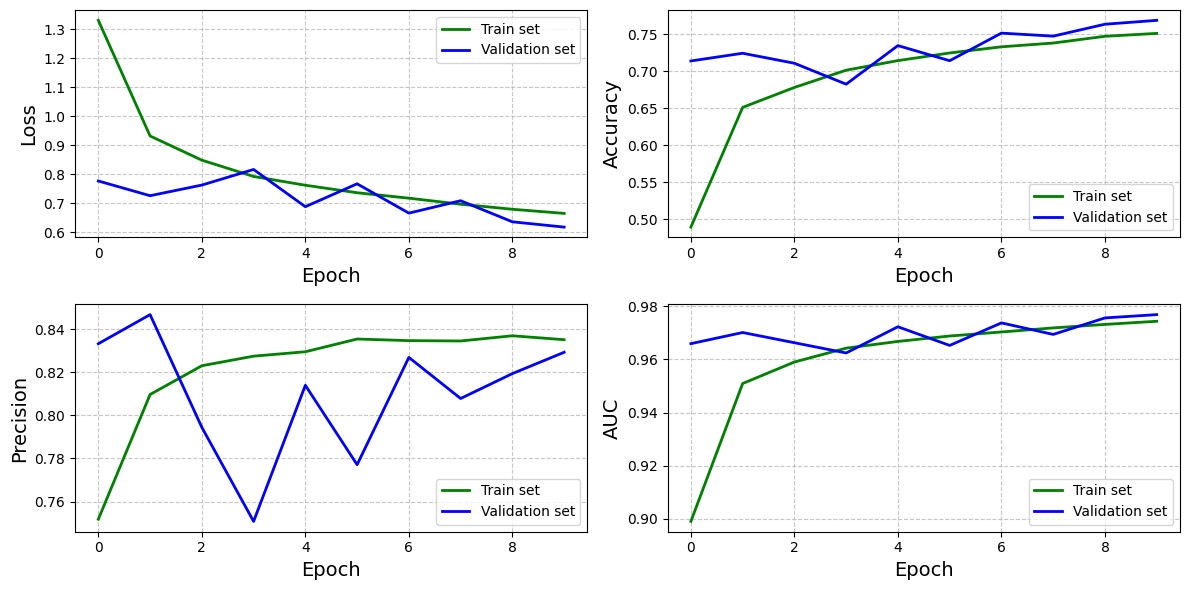

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.plot(metrics["precision"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_precision"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.plot(metrics["auc"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_auc"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [41]:
pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, pred))
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1000
           1       0.98      0.95      0.96      1000
           2       0.61      0.74      0.67      1000
           3       0.80      0.82      0.81      1000
           4       0.70      0.51      0.59      1000
           5       0.73      0.95      0.83      1000
           6       0.47      0.40      0.43      1000
           7       0.88      0.64      0.74      1000
           8       0.90      0.96      0.93      1000
           9       0.95      0.91      0.93      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



array([[815,   0,  39,  58,  10,   5,  53,   0,  20,   0],
       [  7, 953,   1,  26,   6,   2,   3,   0,   2,   0],
       [ 14,   0, 745,  13,  87,   0, 129,   0,  12,   0],
       [ 59,  19,  50, 817,  12,   4,  25,   0,  14,   0],
       [  4,   1, 183,  49, 514,   0, 236,   0,  13,   0],
       [  0,   0,   0,   9,   0, 954,   0,  21,  12,   4],
       [238,   3, 181,  49,  99,   0, 402,   0,  28,   0],
       [  0,   0,   0,   0,   0, 306,   0, 644,   3,  47],
       [  3,   1,  16,   1,   5,   9,   3,   2, 959,   1],
       [  0,   0,   0,   4,   0,  23,   0,  62,   4, 907]])

### Transfer Learning

#### Base Model

In [78]:
os.getcwd()

'/content/drive/MyDrive/DataSets/dogs-vs-cats'

In [79]:
working_dir = "/content/drive/MyDrive/DataSets/dogs-vs-cats"
os.listdir(working_dir)

['train', 'valid', 'test']

In [80]:
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [81]:
train_dataset = image_dataset_from_directory(directory="train", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
validation_dataset = image_dataset_from_directory(directory="valid", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
test_dataset = image_dataset_from_directory(directory="test", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)

Found 996 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [82]:
for data_batch, labels_batch in train_dataset:
  print("data batch:", data_batch.shape, type(data_batch))
  print("labels batch:", labels_batch.shape, type(labels_batch))
  break

data batch: (32, 180, 180, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
labels batch: (32,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [83]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int32)>

In [84]:
def CNN_Builder():
  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")
  inputs = layers.Input(shape=(180, 180, 3), name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Rescaling(1./255, name="rescale")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=1, activation="sigmoid", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='binary_crossentropy',
                metrics=["accuracy"])
  return model

In [85]:
model = CNN_Builder()
model.summary()

Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescale (Rescaling)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_convnet (Conv2D)               │ (None, 179, 179, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool (MaxPooling2D)            │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_convnet (Conv2D)              │ (None, 88, 88, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool (AveragePooling2D)       │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_convnet (Conv2D)               │ (None, 43, 43, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_pool (MaxPooling2D)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 32)                  │         903,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dropout_layer (Dropout)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 928,353 (3.54 MB)

 Trainable params: 928,353 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=5, callbacks=callbacks_list)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.4796 - loss: 0.7140 - val_accuracy: 0.5000 - val_loss: 0.6871
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.5210 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6884
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.5355 - loss: 0.6915 - val_accuracy: 0.5800 - val_loss: 0.6701
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5658 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 0.7490
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5738 - loss: 0.7098 - val_accuracy: 0.5100 - val_loss: 0.9024


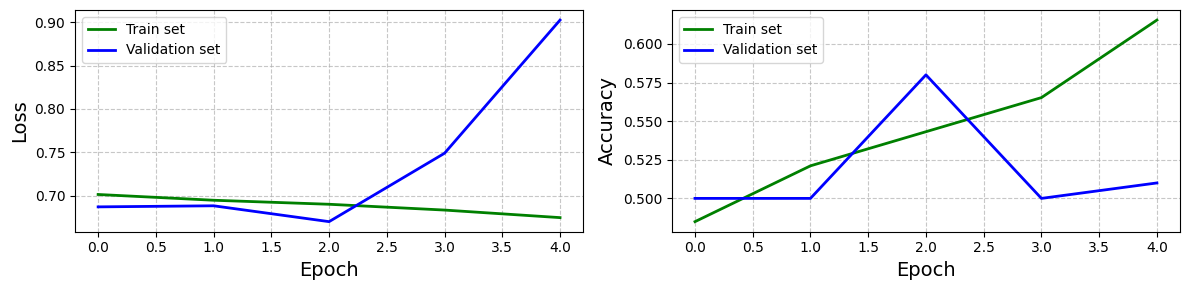

In [87]:
performance = pd.DataFrame(monitor.history)
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(performance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(performance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(performance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(performance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [88]:
model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5262 - loss: 0.8615


[0.8775672316551208, 0.5249999761581421]

#### Feature Extraction Method

In [89]:
conv_base = applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
def get_features_and_labels(dataset):
    features_list = []
    labels_list = []
    for images, labels in dataset:
        preprocessed_images = applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        features_list.append(features)
        labels_list.append(labels)
    return np.concatenate(features_list), np.concatenate(labels_list)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [91]:
inputs = layers.Input(shape=train_features.shape[1:])
features = layers.Flatten()(inputs)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,657 (6.25 MB)

 Trainable params: 1,638,657 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
monitor = model.fit(x=train_features, y=train_labels, epochs=5,
                    validation_data=(val_features, val_labels))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8080 - loss: 34.8051 - val_accuracy: 0.9750 - val_loss: 1.0829
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9678 - loss: 2.6081 - val_accuracy: 0.9800 - val_loss: 0.9977
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.7399 - val_accuracy: 0.9850 - val_loss: 0.2422
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 1.0447 - val_accuracy: 0.9950 - val_loss: 0.2998
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.1104 - val_accuracy: 0.9850 - val_loss: 0.3705


In [93]:
metrics = pd.DataFrame(monitor.history)
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.910643,14.859112,0.975,1.082930
1,0.968876,2.463021,0.980,0.997723
2,0.990964,0.830242,0.985,0.242239
3,0.988956,1.327725,0.995,0.299766
4,0.997992,0.314710,0.985,0.370543


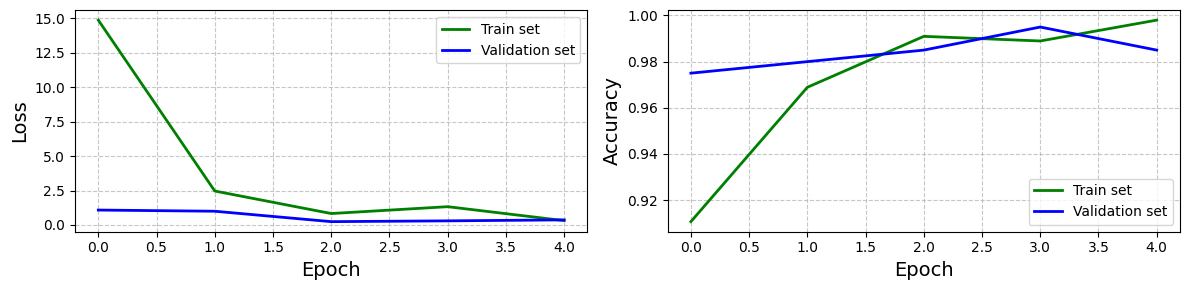

In [94]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [95]:
model.evaluate(test_features, test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9573 - loss: 2.9771 


[2.6345324516296387, 0.9649999737739563]

#### Fine-tuning Method

In [96]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [97]:
inputs = layers.Input(shape=(180, 180, 3))
features = applications.vgg16.preprocess_input(inputs)
features = conv_base(features)
features = layers.Flatten()(features)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs, name="vgg16_fine_tuned")
model.compile(loss="binary_crossentropy",
              optimizer= optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "vgg16_fine_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 180, 180, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 180, 180, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │      1,638,528 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,353,345 (62.38 MB)

 Trainable params: 8,718,081 (33.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [98]:
monitor = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.6177 - loss: 8.7006 - val_accuracy: 0.8900 - val_loss: 0.9129
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8495 - loss: 2.0687 - val_accuracy: 0.8950 - val_loss: 0.7658
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9247 - loss: 0.9084 - val_accuracy: 0.9500 - val_loss: 0.3971
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9269 - loss: 0.5612 - val_accuracy: 0.9450 - val_loss: 0.3371
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9706 - loss: 0.2159 - val_accuracy: 0.9600 - val_loss: 0.2808


In [99]:
y_test = np.array([])
pred = np.array([])
images = []

for batch_img, batch_label in test_dataset:
  y_test = np.concatenate([y_test, batch_label])
  pred  = np.concatenate([pred, model.predict(batch_img, verbose=0).reshape(-1,)])
  images.append(batch_img)

In [100]:
test_images = np.concatenate(images)

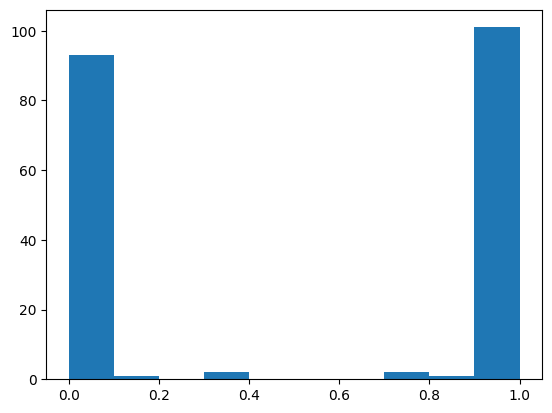

In [101]:
plt.hist(pred)
plt.show()

In [102]:
predictions = np.where(pred>0.5,1,0).reshape(-1,)

In [103]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       100
         1.0       0.90      0.94      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [104]:
confusion_matrix(y_test,predictions)

array([[90, 10],
       [ 6, 94]])